# The intense drought on the Po river basin on summer 2022 

An interesting question one may want to 

<p align="center">
 <a href="https://www.greenandblue.it/2022/07/04/news/siccita_po_e_altri_fiumi_da_satellite-356491116/">
<img src="https://github.com/iacopoff/climetlab-cems-flood/blob/main/climetlab_cems_flood/data/static/img.png">
 </a>
</p>



Article from The Guardian: [Quiet flows the Po: the life and slow death of Italy's longest river](https://www.theguardian.com/environment/2022/jul/10/po-river-italy-drought-climate)

In [1]:
import climetlab as cml
import climetlab_cems_flood as cmf
import matplotlib.pyplot as plt
import datetime
import geopandas as gpd
import pandas as pd

We are going to check...

In [2]:
# pontelagoscuro
ps = {'name':'pontelagoscuro','lat':44.886111, 'lon':11.604444}

In [11]:
seasonal = cml.load_dataset(
            'glofas-seasonal',
            model='lisflood',
            system_version='operational',
            temporal_filter= '2022 01-08 *',
            leadtime_hour = '24-3600',
            variable="river_discharge_in_the_last_24_hours",
            coords=[ps], 
            split_on=["month"],
            threads= 9
)

In [18]:
water_balance = cml.load_dataset(
            'glofas-historical',
            model='lisflood',
            product_type='intermediate',
            system_version='version_3_1',
            temporal_filter= '2022 01-08 *',
            variable="river_discharge_in_the_last_24_hours",
            coords=[ps],
            split_on = ['hmonth'],
            threads = 6
        )

In [13]:
water_2003 = cml.load_dataset(
            'glofas-historical',
            model='lisflood',
            product_type='consolidated',
            system_version='version_3_1',
            temporal_filter= '2003 01-08 *',
            variable="river_discharge_in_the_last_24_hours",
            coords=[ps],
            split_on = ['hmonth'],
            threads = 6
        )

In [14]:
climatology_2000_2021 = cml.load_dataset(
            'glofas-historical',
            model='lisflood',
            product_type='consolidated',
            system_version='version_3_1',
            temporal_filter= '2000-2021 01-10 *',
            variable="river_discharge_in_the_last_24_hours",
            coords=[ps],
            split_on = ['hyear','hmonth'],
            threads = 10
        )

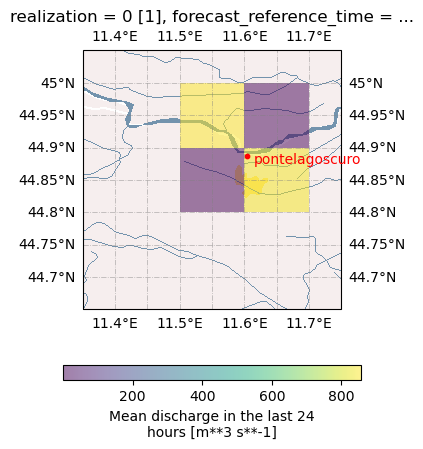

In [36]:
seasonal.show_coords('ponte')

In [19]:
seas = seasonal.to_xarray()

In [21]:
wb = water_balance.to_xarray()

AssertionError: Not all GRIB fields were converted to xarray (251 GRIBs > 243 2D-field(s) in xarray)

In [20]:
cl = climatology_2000_2021.to_xarray()

In [22]:
wb

NameError: name 'wb' is not defined

In [23]:
wb_2003 = water_2003.to_xarray()

In [24]:
wb_2003

<xarray.Dataset>
Dimensions:    (time: 243, latitude: 2, longitude: 2)
Coordinates:
  * time       (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2003-08-31
  * latitude   (latitude) float64 44.95 44.85
  * longitude  (longitude) float64 11.55 11.65
Data variables:
    dis24      (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-01-03T18:44 GRIB to CDM+CF via cfgrib-0.9.1...

In [25]:
wb_2003 = wb_2003.sel(time=slice("2003-01-01","2003-08-13"))
wb_2003.dis24.shape

(225, 2, 2)

In [26]:
wb_2003["time"] = wb["time"]

NameError: name 'wb' is not defined

In [43]:
cl = cl.chunk({"time":500})
cmean = cl.groupby("time.dayofyear").mean()
cmin = cl.groupby("time.dayofyear").min()
cmax = cl.groupby("time.dayofyear").max()

cmax = cmax.where(cmax.dayofyear != cmax.dayofyear[59], drop =True)

cmin = cmin.where(cmin.dayofyear != cmin.dayofyear[59], drop =True)

cmean = cmean.where(cmean.dayofyear != cmean.dayofyear[59], drop =True)

In [44]:
cmean

<xarray.Dataset>
Dimensions:    (dayofyear: 304, latitude: 2, longitude: 2)
Coordinates:
  * latitude   (latitude) float64 44.95 44.85
  * longitude  (longitude) float64 11.55 11.65
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 299 300 301 302 303 304 305
Data variables:
    dis24      (dayofyear, latitude, longitude) float32 dask.array<chunksize=(1, 2, 2), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-01-03T18:44 GRIB to CDM+CF via cfgrib-0.9.1...

In [45]:
# seas = seas.rio.write_crs("EPSG:4326")
# cmean = cmean.rio.write_crs("EPSG:4326")
# wb = wb.rio.write_crs("EPSG:4326")

In [46]:
# seas = seas.rio.clip(gdf_diss.geometry)
# wb = wb.rio.clip(gdf_diss.geometry)
# cmean = cmean.rio.clip(gdf_diss.geometry)

In [47]:
cmean["time"] =  pd.date_range("2022-01-01","2022-10-31")
cmin["time"]=  pd.date_range("2022-01-01","2022-10-31")
cmax["time"] =  pd.date_range("2022-01-01","2022-10-31")

In [48]:
# plt.figure(figsize=(20,10))
# seas.dis24.isel(realization=0,leadtime=0,forecast_reference_time=0).plot()
# plt.scatter(ps[1],ps[0],s=10,color="red")

In [49]:
seas = seas.sel(lat=ps['lat'],lon=ps['lon'],method="nearest")

In [56]:
cmean = cmean.sel(latitude=ps['lat'],longitude=ps['lon'],method="nearest")

cmax= cmax.sel(latitude=ps['lat'],longitude=ps['lon'],method="nearest")

cmin = cmin.sel(latitude=ps['lat'],longitude=ps['lon'],method="nearest")

#wb = wb.sel(latitude=ps[0],longitude=ps[1],method="nearest")

In [55]:
wb_2003 = wb_2003.sel(latitude=ps['lat'],longitude=ps['lon'],method="nearest")

In [57]:
wb_2003

<xarray.Dataset>
Dimensions:    (time: 225)
Coordinates:
  * time       (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2003-08-13
    latitude   float64 44.85
    longitude  float64 11.65
Data variables:
    dis24      (time) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-01-03T18:44 GRIB to CDM+CF via cfgrib-0.9.1...

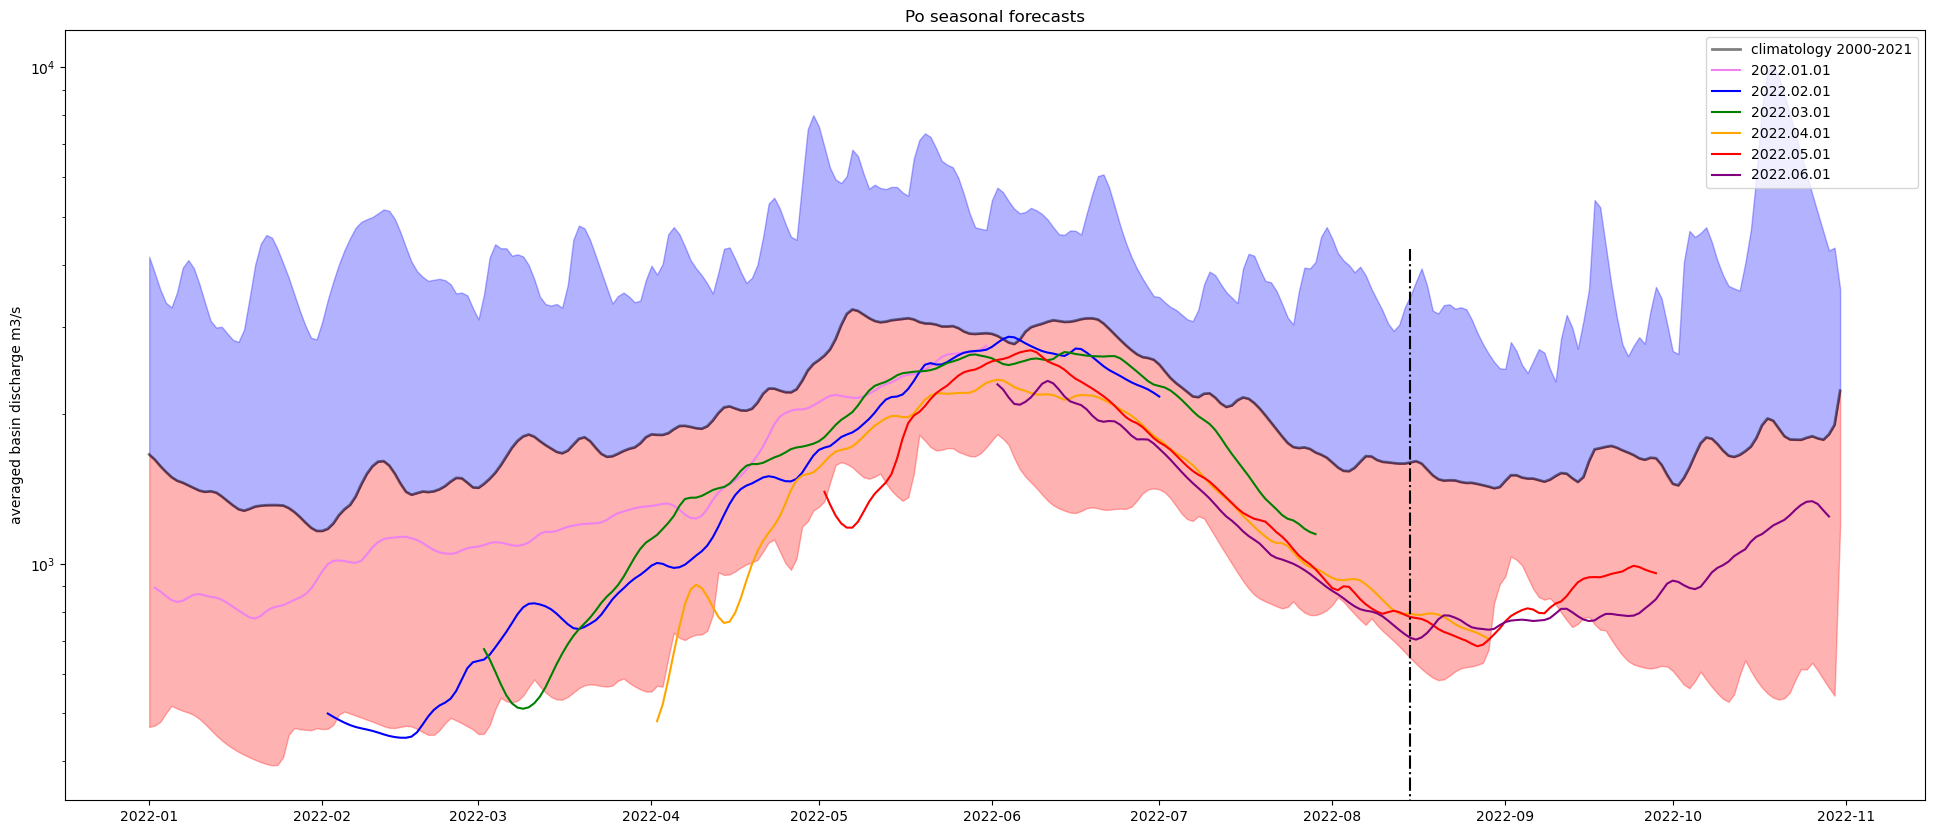

In [59]:
plt.figure(figsize=(24,10))

plt.fill_between(cmin.time.values,cmean.dis24.values.T,cmax.dis24.values.T,color="blue",alpha=0.3)
plt.fill_between(cmin.time.values,cmin.dis24.values.T,cmean.dis24.values.T,color="red",alpha=0.3)
plt.plot(cmean.time.values,cmean.dis24.values.T, linewidth=2, color="black",label = "climatology 2000-2021", alpha=0.5)

for i,c in enumerate(["violet","blue","green","orange","red","purple"]):
    t = seas.dis24.forecast_reference_time[i].values
    t = pd.to_datetime(t).strftime('%Y.%m.%d')
    m = seas.dis24.isel(forecast_reference_time=i,drop=True)
    plt.plot(m.time.values, m.mean("realization").values.T,color=c, label=t)
#plt.scatter(wb.time.values,wb.dis24.values.T,color="black",s=10, label="water balance", alpha=0.7)
# plt.scatter(wb_2003.time.values,wb_2003.dis24.values.T,color="red",s=12, label="water balance 2003", alpha=0.7)
plt.vlines(x=datetime.datetime(2022,8,15),ymin=0,ymax=4300,linestyle="-.", color="black")
plt.legend()
plt.ylabel("averaged basin discharge m3/s") 
plt.title("Po seasonal forecasts")
plt.yscale("log")

In [67]:
seas = seas.sel(lat=cm[0],lon=cm[1],method="nearest")

cmean = cmean.sel(latitude=cm[0],longitude=cm[1],method="nearest")

cmax= cmax.sel(latitude=cm[0],longitude=cm[1],method="nearest")

cmin = cmin.sel(latitude=cm[0],longitude=cm[1],method="nearest")

wb = wb.sel(latitude=cm[0],longitude=cm[1],method="nearest")

wb_2003 = wb_2003.sel(latitude=cm[0],longitude=cm[1],method="nearest")

In [ ]:
plt.figure(figsize=(24,10))

plt.fill_between(cmin.time.values,cmean.dis24.values.T,cmax.dis24.values.T,color="blue",alpha=0.3)
plt.fill_between(cmin.time.values,cmin.dis24.values.T,cmean.dis24.values.T,color="red",alpha=0.3)
plt.plot(cmean.time.values,cmean.dis24.values.T, linewidth=2, color="black",label = "climatology 2000-2021", alpha=0.5)

for i,c in enumerate(["violet","blue","green","orange","red","purple"]):
    t = seas.dis24.forecast_reference_time[i].values
    t = pd.to_datetime(t).strftime('%Y.%m.%d')
    m = seas.dis24.isel(forecast_reference_time=i,drop=True)
    plt.plot(m.time.values, m.mean("realization").values.T,color=c, label=t)
#plt.scatter(wb.time.values,wb.dis24.values.T,color="black",s=10, label="water balance", alpha=0.7)
# plt.scatter(wb_2003.time.values,wb_2003.dis24.values.T,color="red",s=12, label="water balance 2003", alpha=0.7)
plt.vlines(x=datetime.datetime(2022,8,15),ymin=0,ymax=4300,linestyle="-.", color="black")
plt.legend()
plt.ylabel("averaged basin discharge m3/s") 
plt.title("Po seasonal forecasts")
plt.yscale("log")

In [83]:
seas = seas.sel(lat=ca[0],lon=ca[1],method="nearest")

cmean = cmean.sel(latitude=ca[0],longitude=ca[1],method="nearest")

cmax= cmax.sel(latitude=ca[0],longitude=ca[1],method="nearest")

cmin = cmin.sel(latitude=ca[0],longitude=ca[1],method="nearest")

wb = wb.sel(latitude=ca[0],longitude=ca[1],method="nearest")

wb_2003 = wb_2003.sel(latitude=ca[0],longitude=ca[1],method="nearest")

/home/iacopo/.pyenv/versions/riverv-dev/lib/python3.10/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/iacopo/.pyenv/versions/riverv-dev/lib/python3.10/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


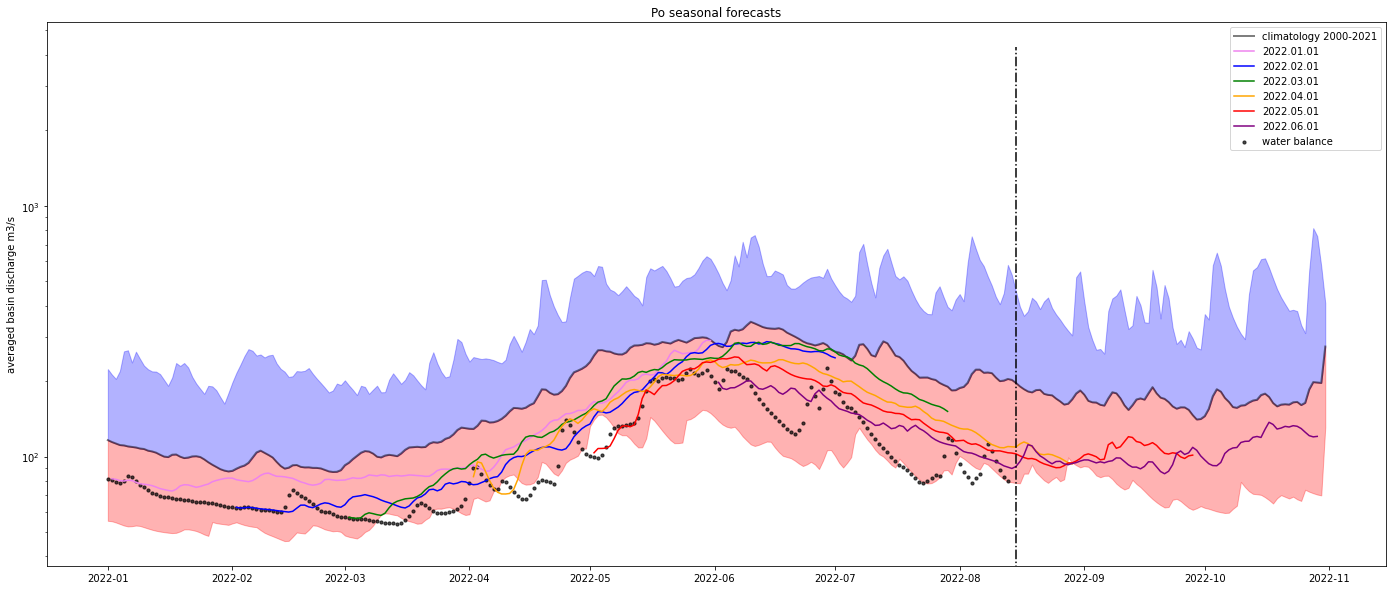

In [84]:
plt.figure(figsize=(24,10))

plt.fill_between(cmin.time.values,cmean.dis24.values.T,cmax.dis24.values.T,color="blue",alpha=0.3)
plt.fill_between(cmin.time.values,cmin.dis24.values.T,cmean.dis24.values.T,color="red",alpha=0.3)
plt.plot(cmean.time.values,cmean.dis24.values.T, linewidth=2, color="black",label = "climatology 2000-2021", alpha=0.5)

for i,c in enumerate(["violet","blue","green","orange","red","purple"]):
    t = seas.dis24.forecast_reference_time[i].values
    t = pd.to_datetime(t).strftime('%Y.%m.%d')
    m = seas.dis24.isel(forecast_reference_time=i,drop=True)
    plt.plot(m.time.values, m.mean("realization").values.T,color=c, label=t)
plt.scatter(wb.time.values,wb.dis24.values.T,color="black",s=10, label="water balance", alpha=0.7)
# plt.scatter(wb_2003.time.values,wb_2003.dis24.values.T,color="red",s=12, label="water balance 2003", alpha=0.7)
plt.vlines(x=datetime.datetime(2022,8,15),ymin=0,ymax=4300,linestyle="-.", color="black")
plt.legend()
plt.ylabel("averaged basin discharge m3/s") 
plt.title("Po seasonal forecasts")
plt.yscale("log")

In [5]:
from climetlab_cems_flood.utils import show_request_for_parameter

In [19]:
show_request_for_parameter('cems-glofas-seasonal', 'temporal_filter', '* 07 *')

years: ['2019', '2020', '2021', '2022']
months: ['07']
days: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']
